# F-Stock Network Granger Causality Analysis
This analysis aims to answer the queation: which stocks' price monvement can be Granger casued by the stocks' aggregated popularity(attention) and inverstor sentiment?

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
sns.set(rc={'figure.figsize':(16,8)})
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import warnings
import networkx as nx
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib_venn import venn2

In [ ]:
whole = pd.read_csv('by_day_400to500.csv').drop(columns = ['Unnamed: 0', 'symbol_lis','sym_num'])
stock_df_to_get_lis = pd.read_csv('bull_rate_stock.csv').drop(columns = ['Unnamed: 0'])

In [ ]:
stock_lis = {i for i in stock_df_to_get_lis['ticker']}
use = whole.loc[whole['symbol'].isin(stock_lis)]

In [ ]:
sd = '2018-03-01'
ed = '2020-03-01'
use.head()

,message_id,user_id,sentiment,symbol,date,week,sent_num,week_num
0,116703116,932046,Bearish,KA,2018-03-19,201812,0,400
3,116703150,853336,Bearish,VIVE,2018-03-19,201812,0,400
7,116703169,1446811,Bullish,FNKO,2018-03-19,201812,1,400
12,116703194,1322978,Bullish,MYMD,2018-03-19,201812,1,400
22,116703248,1339432,Bullish,XXII,2018-03-19,201812,1,400


## Get features

### Get popularity and sentiment features

In [ ]:
use1 = use.drop(columns = ['sentiment','week','week_num'])
popu = use1.groupby(by = ['symbol','date']).agg({'message_id':'count', 'user_id':pd.Series.nunique, 'sent_num':'sum'}).rename(columns = {'message_id':'mes_count','user_id':'user_count'}).reset_index()

In [ ]:
popu['total_bull_rate'] = popu['sent_num'] / popu['mes_count']

In [ ]:
by_user = use1.groupby(by = ['symbol','date','user_id']).agg({'message_id':'count', 'sent_num':'sum'}).rename(
    columns = {'message_id':'mes_cnt_by_user'
              ,'sent_num':'sent_num_by_user'}).reset_index()
by_user['user_bull_rate'] = by_user['sent_num_by_user'] / by_user['mes_cnt_by_user']

In [ ]:
by_user['bull_user'] = (by_user['user_bull_rate']>0.5).astype(int)

In [ ]:
by_user.head()

,symbol,date,user_id,mes_cnt_by_user,sent_num_by_user,user_bull_rate,bull_user
0,AA,2018-03-19,75605,1,1,1.0,1
1,AA,2018-03-19,493790,1,0,0.0,0
2,AA,2018-03-21,75605,1,1,1.0,1
3,AA,2018-03-21,1185191,1,1,1.0,1
4,AA,2018-03-22,75303,1,1,1.0,1


In [ ]:
sub = by_user[['symbol','date','user_bull_rate','bull_user']].groupby(by = ['symbol','date']).agg({'user_bull_rate':'mean',
                                                                                       'bull_user':'sum'}).reset_index()
popu = popu.merge(sub,on = ['symbol','date'])

In [ ]:
popu['bull_user_rate'] = popu['bull_user'] / popu['user_count']

In [ ]:
popu.head()

,symbol,date,mes_count,user_count,sent_num,total_bull_rate,user_bull_rate,bull_user,bull_user_rate
0,AA,2018-03-19,2,2,1,0.50,0.50,1,0.50
1,AA,2018-03-21,2,2,2,1.00,1.00,2,1.00
2,AA,2018-03-22,4,4,3,0.75,0.75,3,0.75
3,AA,2018-03-24,1,1,1,1.00,1.00,1,1.00
4,AA,2018-03-25,1,1,0,0.00,0.00,0,0.00


In [ ]:
popu.to_csv('popularity_features.csv')

### Network features

In [ ]:
by_user.head()

,symbol,date,user_id,mes_cnt_by_user,sent_num_by_user,user_bull_rate,bull_user
0,AA,2018-03-19,75605,1,1,1.0,1
1,AA,2018-03-19,493790,1,0,0.0,0
2,AA,2018-03-21,75605,1,1,1.0,1
3,AA,2018-03-21,1185191,1,1,1.0,1
4,AA,2018-03-22,75303,1,1,1.0,1


In [ ]:
sub1 = by_user[['date','user_id','mes_cnt_by_user']].groupby(by = ['date','user_id']).sum().rename(columns = {'mes_cnt_by_user':'tt_mes_cnt_by_user'}).reset_index()
by_user_1 = by_user.merge(sub1, on = ['date','user_id'])
by_user_1['user_weight'] = by_user_1['mes_cnt_by_user'] / by_user_1['tt_mes_cnt_by_user']

In [ ]:
by_user_1.head()

,symbol,date,user_id,mes_cnt_by_user,sent_num_by_user,user_bull_rate,bull_user,tt_mes_cnt_by_user,user_weight
0,AA,2018-03-19,75605,1,1,1.0,1,12,0.083333
1,AA,2018-03-19,493790,1,0,0.0,0,5,0.200000
2,AA,2018-03-21,75605,1,1,1.0,1,25,0.040000
3,AA,2018-03-21,1185191,1,1,1.0,1,7,0.142857
4,AA,2018-03-22,75303,1,1,1.0,1,1,1.000000


In [ ]:
g_df = []
ds = list({i for i in by_user_1['date']})
count = 0
for D in ds:
  day = by_user_1.loc[by_user_1['date'] == D]
  sub3 = day[['symbol','user_weight']].groupby(by = ['symbol']).sum().reset_index()
  sub2 = day[['user_id','symbol']].merge(day[['user_id','symbol']], on = ['user_id'], suffixes = ['_st1','_st2'])
  net = sub2.loc[sub2['symbol_st1'] != sub2['symbol_st2']].groupby(['symbol_st1','symbol_st2']).count().reset_index().rename(columns= {'user_id':'edge_weight'})
  G = nx.Graph()
  node_set = set()
  edge_set = set()
  for i,d in net.iterrows():
      node1, node2 = d['symbol_st1'],d['symbol_st2']
      w = 1/ d['edge_weight']
      G.add_node(node1)
      G.add_node(node2)
      G.add_edge(node1, node2, weight = w)
  bc_w = pd.DataFrame(nx.betweenness_centrality(G, weight = 'weight').items(), columns=['symbol', 'weighted_btwn_centrality'])
  bc = pd.DataFrame(nx.betweenness_centrality(G).items(), columns=['symbol', 'btwn_centrality'])
  # eigen = pd.DataFrame(nx.eigenvector_centrality(G).items(), columns=['symbol', 'eigenvector_centrality'])
  degree = pd.DataFrame(dict(G.degree()).items(), columns=['symbol', 'degree_centrality'])
  # Compute weighted degree centrality
  degree2 = pd.DataFrame(dict(G.degree(weight='weight')).items(), columns=['symbol', 'weighted_degree_centrality'])
  dfs = [df.set_index(['symbol']) for df in [sub3,bc_w,bc,degree,degree2]]
  D_result = pd.concat(dfs, axis=1).reset_index()
  D_result['date'] = D
  g_df.append(D_result)
  count+=1
  if count % 20 == 0:
    print(count, ' days finishied')
net_features = pd.concat(g_df)
# net_features = pd.read_csv('network_features.csv')

20  days finishied
40  days finishied
60  days finishied
80  days finishied
100  days finishied
120  days finishied
140  days finishied
160  days finishied
180  days finishied
200  days finishied
220  days finishied
240  days finishied
260  days finishied
280  days finishied
300  days finishied
320  days finishied
340  days finishied
360  days finishied
380  days finishied
400  days finishied
420  days finishied
440  days finishied
460  days finishied
480  days finishied
500  days finishied
520  days finishied
540  days finishied
560  days finishied
580  days finishied
600  days finishied
620  days finishied
640  days finishied
660  days finishied
680  days finishied
700  days finishied


In [ ]:
net_features.head()

,symbol,user_weight,weighted_btwn_centrality,btwn_centrality,degree_centrality,weighted_degree_centrality,date
0,AA,0.046999,0.000018,0.000244,173.0,164.00000,2019-04-24
1,AACG,0.142857,0.000000,0.000000,6.0,6.00000,2019-04-24
2,AAL,0.147692,0.000004,0.000103,171.0,167.50000,2019-04-24
3,AAOI,1.733333,0.000000,0.000013,3.0,3.00000,2019-04-24
4,AAPL,40.223282,0.014503,0.021879,209.0,183.72123,2019-04-24


In [ ]:
popu.head()

,symbol,date,mes_count,user_count,sent_num,total_bull_rate,user_bull_rate,bull_user,bull_user_rate
0,AA,2018-03-19,2,2,1,0.50,0.50,1,0.50
1,AA,2018-03-21,2,2,2,1.00,1.00,2,1.00
2,AA,2018-03-22,4,4,3,0.75,0.75,3,0.75
3,AA,2018-03-24,1,1,1,1.00,1.00,1,1.00
4,AA,2018-03-25,1,1,0,0.00,0.00,0,0.00


## Granger test

In [ ]:
net_feature = pd.read_csv('network_features.csv').drop(columns = 'Unnamed: 0')
popu_feature = pd.read_csv('popularity_features.csv').drop(columns = 'Unnamed: 0')
sd = '2018-03-01'
ed = '2020-03-01'

In [ ]:
net_feature.head()

,symbol,user_weight,weighted_btwn_centrality,btwn_centrality,degree_centrality,weighted_degree_centrality,date
0,AA,0.046999,0.000018,0.000244,173.0,164.00000,2019-04-24
1,AACG,0.142857,0.000000,0.000000,6.0,6.00000,2019-04-24
2,AAL,0.147692,0.000004,0.000103,171.0,167.50000,2019-04-24
3,AAOI,1.733333,0.000000,0.000013,3.0,3.00000,2019-04-24
4,AAPL,40.223282,0.014503,0.021879,209.0,183.72123,2019-04-24


In [ ]:
popu_feature.head()

,symbol,date,mes_count,user_count,sent_num,total_bull_rate,user_bull_rate,bull_user,bull_user_rate
0,AA,2018-03-19,2,2,1,0.50,0.50,1,0.50
1,AA,2018-03-21,2,2,2,1.00,1.00,2,1.00
2,AA,2018-03-22,4,4,3,0.75,0.75,3,0.75
3,AA,2018-03-24,1,1,1,1.00,1.00,1,1.00
4,AA,2018-03-25,1,1,0,0.00,0.00,0,0.00


In [ ]:
use = popu_feature.merge(net_feature, on = ['symbol', 'date'])
use.shape

(339910, 14)

In [ ]:
stock_lis = list({i for i in use['symbol']})
print(len(stock_lis))
stock_df = []
for t in stock_lis:
  try:
    sub = yf.download(t,sd,ed)
    sub.columns = [col[0] for col in sub.columns]
    # Step 2: Reset index to make "Date" a column
    sub.reset_index(inplace=True)
    sub = sub[['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']].rename(columns= {'Date':'date'})
    sub['symbol'] = t
    stock_df.append(sub)
  except:
    print(t, ' failed')
    pass
stock_df = pd.concat(stock_df)

698


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
stock_df.head()

,date,Adj Close,Close,High,Low,Open,Volume,symbol
0,2018-03-01,10.323714,10.718000,11.402667,10.333333,11.282000,14397000.0,SOXL
1,2018-03-02,10.857331,11.272000,11.331333,10.258000,10.258000,9610500.0,SOXL
2,2018-03-05,11.153360,11.579333,11.740000,10.933333,11.105333,8790000.0,SOXL
3,2018-03-06,11.657439,12.102667,12.190667,11.716667,11.853333,12933000.0,SOXL
4,2018-03-07,11.749267,12.198000,12.256667,11.733333,11.750667,9990000.0,SOXL


In [ ]:
use1 = []
use['date'] = pd.to_datetime(use['date'])
for t in stock_lis:
  sub1 = use.loc[use['symbol'] == t].drop(columns = 'symbol').sort_values(by = 'date')
  sub2 = stock_df.loc[stock_df['symbol'] == t]
  sub3 = pd.merge_asof(sub1, sub2, on = 'date').drop(columns = ['High','Low'])
  use1.append(sub3)
use1 = pd.concat(use1)


In [ ]:
use1['bear_mes'] = use1['mes_count'] - use1['sent_num']
use1['bear_user'] = use1['user_count'] - use1['bull_user']

In [ ]:
use1.head()

,date,mes_count,user_count,sent_num,total_bull_rate,user_bull_rate,bull_user,bull_user_rate,user_weight,weighted_btwn_centrality,btwn_centrality,degree_centrality,weighted_degree_centrality,Adj Close,Close,Open,Volume,symbol,bear_mes,bear_user
0,2018-03-19,16,16,11,0.687500,0.636364,7,0.437500,9.250000,0.0,0.000067,4.0,4.0,11.559834,12.001333,12.408000,17712000.0,SOXL,5,9
1,2018-03-20,5,5,3,0.600000,0.600000,3,0.600000,5.000000,NaN,NaN,NaN,NaN,11.830176,12.282000,12.066667,8823000.0,SOXL,2,2
2,2018-03-21,12,12,12,1.000000,1.000000,7,0.583333,4.916667,0.0,0.000108,7.0,6.5,11.910442,12.365333,12.196000,9939000.0,SOXL,0,5
3,2018-03-22,10,10,5,0.500000,0.437500,3,0.300000,7.000000,0.0,0.000000,2.0,2.0,10.932461,11.350000,11.782000,15714000.0,SOXL,5,7
4,2018-03-23,13,13,9,0.692308,0.750000,6,0.461538,5.803030,0.0,0.000228,5.0,5.0,9.838897,10.214667,11.284667,16557000.0,SOXL,4,7


In [ ]:
def check_stationary(use4, show = False):
  stay,change = [],[]
  for i in range(len(use4.columns)):
    result = adfuller(use4[use4.columns[i]])
    if result[1]>0.05:
      if show:
        print(f'{use4.columns[i]} is not stationary')
      change.append(use4.columns[i])
    else:
      if show:
        print(f'{use4.columns[i]} is stationary')
      stay.append(use4.columns[i])
  return stay,change

def make_stationary(use4):
  s,c = check_stationary(use4)
  if len(c) > 0:
    stay = use4[s]
    non_stay = use4[c]
    reform = non_stay.diff().dropna()
    make_stationary(reform)
    use5 = pd.concat([stay, reform], axis=1).dropna()
    return use5
  else:
    return use4

def gctest(use5, y, max_lag = 5):
  dic = {}
  for i in range(len(use5.columns)):
    col = use5.columns[i]
    if col != y:
      result = grangercausalitytests(use5[[y,col]], max_lag, verbose = False)
      p_values = [round(result[i+1][0]['ssr_ftest'][1],4) for i in range(max_lag)]
      dic[col] = p_values
  gcdf = pd.DataFrame(dic)
  return gcdf.reset_index().rename(columns = {'index':'lag'})

In [ ]:
use_save = use1.copy()

In [ ]:
# use1 = use_save

In [ ]:
use1 = use1[['date','symbol','mes_count', 'user_count','total_bull_rate','user_bull_rate','Close']]

In [ ]:
gc = []
fails = []
for t in stock_lis:
  try:
    sub = use1.loc[use1['symbol'] == t].drop(columns = 'symbol').set_index('date')
    sub2 = make_stationary(sub)
    sub3 = gctest(sub2, 'Close', max_lag = 5)
    sub3['ticker'] = t
    gc.append(sub3)
  except:
    print(t,' failed')
    fails.append(t)
    pass
gc = pd.concat(gc)

APRN  failed
ATVI  failed
CBIO  failed
VBIV  failed
ATHX  failed
AGRX  failed
SQQQ  failed
ABIO  failed
NVTA  failed
ASAP  failed
BIOC  failed
NLTX  failed
ASXC  failed
GLG  failed
ABMD  failed
LL  failed
KERN  failed
ENDPQ  failed
RAD  failed
TMBR  failed
RETA  failed
SPLK  failed
TWOU  failed
INPX  failed
NVIV  failed
RWLK  failed
MYMD  failed
GPS  failed
CFRX  failed
PRTK  failed
ISUN  failed
OCUP  failed
SWN  failed
YGYI  failed
ACRX  failed
VMW  failed
DMTK  failed
PLM  failed
SPWR  failed
OSTK  failed
BLCM  failed
NEPT  failed
NHWK  failed
AYX  failed
SUNW  failed
AEZS  failed
INFI  failed
ZYNE  failed
SELB  failed
ICPT  failed
CBAY  failed
LIFE  failed
PHASQ  failed
CPE  failed
JAN  failed
BIG  failed
ACOR  failed
IMGN  failed
SOLO  failed
IDXG  failed
CONN  failed
KA  failed
MRTX  failed
ONTX  failed
HSTO  failed
CEI  failed


In [ ]:
gc.to_csv('gc_test_result.csv')

In [ ]:
gc.shape

(3160, 6)

In [ ]:
net_feature.columns

Index(['symbol', 'user_weight', 'weighted_btwn_centrality', 'btwn_centrality',
       'degree_centrality', 'weighted_degree_centrality', 'date'],
      dtype='object')

In [ ]:
avg_net = net_feature[['symbol', 'user_weight', 'weighted_btwn_centrality', 'btwn_centrality',
       'degree_centrality', 'weighted_degree_centrality']].groupby(by = 'symbol').mean().reset_index().rename(columns = {'symbol':'ticker'})

In [ ]:
gcuse = gc.merge(avg_net, on = 'ticker')

In [ ]:
gcuse.head()

,lag,mes_count,user_count,total_bull_rate,user_bull_rate,ticker,user_weight,weighted_btwn_centrality,btwn_centrality,degree_centrality,weighted_degree_centrality
0,0,0.2573,0.2573,0.1377,0.2315,SOXL,3.065441,0.000253,0.00042,15.269807,14.848394
1,1,0.5168,0.5168,0.0900,0.1286,SOXL,3.065441,0.000253,0.00042,15.269807,14.848394
2,2,0.7343,0.7343,0.1506,0.2558,SOXL,3.065441,0.000253,0.00042,15.269807,14.848394
3,3,0.8058,0.8058,0.1350,0.2519,SOXL,3.065441,0.000253,0.00042,15.269807,14.848394
4,4,0.8883,0.8883,0.1569,0.2366,SOXL,3.065441,0.000253,0.00042,15.269807,14.848394


In [ ]:
test_f = 'mes_count'
by_f = 'degree_centrality'
test_use = gcuse[['lag',test_f,by_f,'ticker']]

In [ ]:
# Step 1: Add the 'significant' column
test_use['significant'] = (test_use[test_f] < 0.05).astype(int)

# Step 2: Add the '{by_f}_quantile' column
quantile_col_name = f"{by_f}_quantile"
test_use[quantile_col_name] = test_use.groupby('lag')[by_f].transform(
    lambda x: pd.qcut(x.rank(method='first'), 10, labels=[0.1 * i for i in range(1, 11)])
)

<ipython-input-98-f27c79aba950>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_use['significant'] = (test_use[test_f] < 0.05).astype(int)
<ipython-input-98-f27c79aba950>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_use[quantile_col_name] = test_use.groupby('lag')[by_f].transform(


In [ ]:
# Step 1: Group by 'lag' and 'by_f_quantile' and calculate the average significance
rate_of_significance = test_use.groupby(['lag', quantile_col_name])['significant'].mean().reset_index()

# Step 2: Rename the column for clarity
rate_of_significance.rename(columns={'significant': 'rate_of_significance'}, inplace=True)


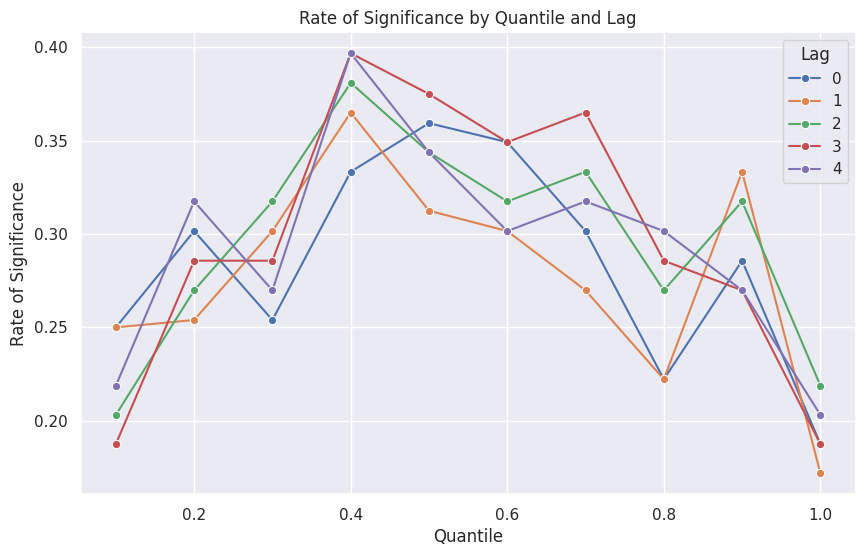

In [ ]:
# Ensure 'lag' is treated as a categorical variable
rate_of_significance['lag'] = rate_of_significance['lag'].astype('category')

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=rate_of_significance, x=quantile_col_name, y='rate_of_significance', hue='lag', marker='o')

# Customize the plot
plt.title('Rate of Significance by Quantile and Lag')
plt.xlabel('Quantile')
plt.ylabel('Rate of Significance')
plt.legend(title='Lag')

# Show the plot
plt.show()

In [ ]:
def check_plot(test_f,by_f, t_name, by_name):
  test_use = gcuse[['lag',test_f,by_f,'ticker']]
  test_use = test_use.loc[test_use['lag']!=0]
  # Step 1: Add the 'significant' column
  test_use['significant'] = (test_use[test_f] < 0.05).astype(int)

  # Step 2: Add the '{by_f}_quantile' column
  quantile_col_name = f"{by_f}_quantile"
  test_use[quantile_col_name] = test_use.groupby('lag')[by_f].transform(
      lambda x: pd.qcut(x.rank(method='first'), 5, labels=[0.2 * i for i in range(1, 6)])
  )
  # Step 1: Group by 'lag' and 'by_f_quantile' and calculate the average significance
  rate_of_significance = test_use.groupby(['lag', quantile_col_name])['significant'].mean().reset_index()

  # Step 2: Rename the column for clarity
  rate_of_significance.rename(columns={'significant': 'rate_of_significance'}, inplace=True)
  # Ensure 'lag' is treated as a categorical variable
  rate_of_significance['lag'] = rate_of_significance['lag'].astype('category')

  # Create the plot
  plt.figure(figsize=(10, 6))
  sns.lineplot(data=rate_of_significance, x=quantile_col_name, y='rate_of_significance', hue='lag', marker='o')

  # Customize the plot
  plt.title(f'Rate of Significance for Granger Causality testing ({t_name}, close price), by {by_name} Quantile and Lag')
  plt.xlabel(f'Quantile of {by_name}')
  plt.ylabel('Rate of Significance')
  plt.legend(title='Lag')

  # Show the plot
  plt.show()

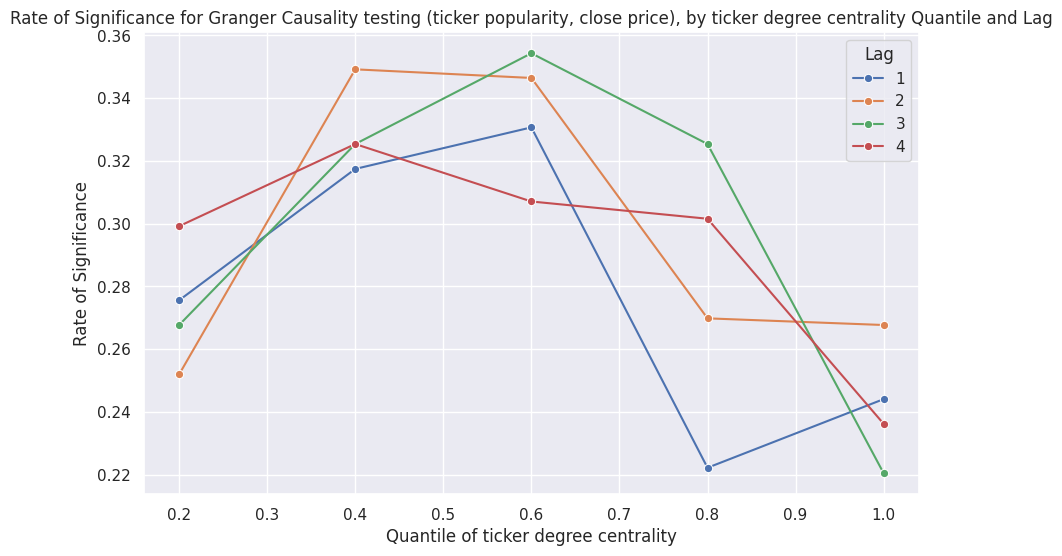

In [ ]:
check_plot(test_f = 'mes_count',by_f = 'weighted_degree_centrality', t_name = 'ticker popularity', by_name = 'ticker degree centrality')

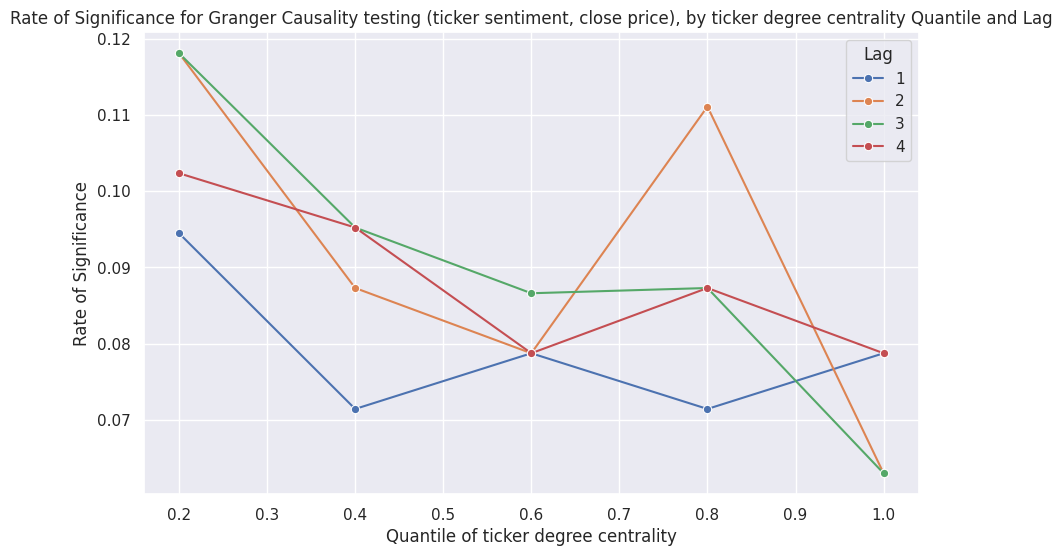

In [ ]:
check_plot(test_f = 'total_bull_rate',by_f = 'weighted_degree_centrality', t_name = 'ticker sentiment', by_name = 'ticker degree centrality')

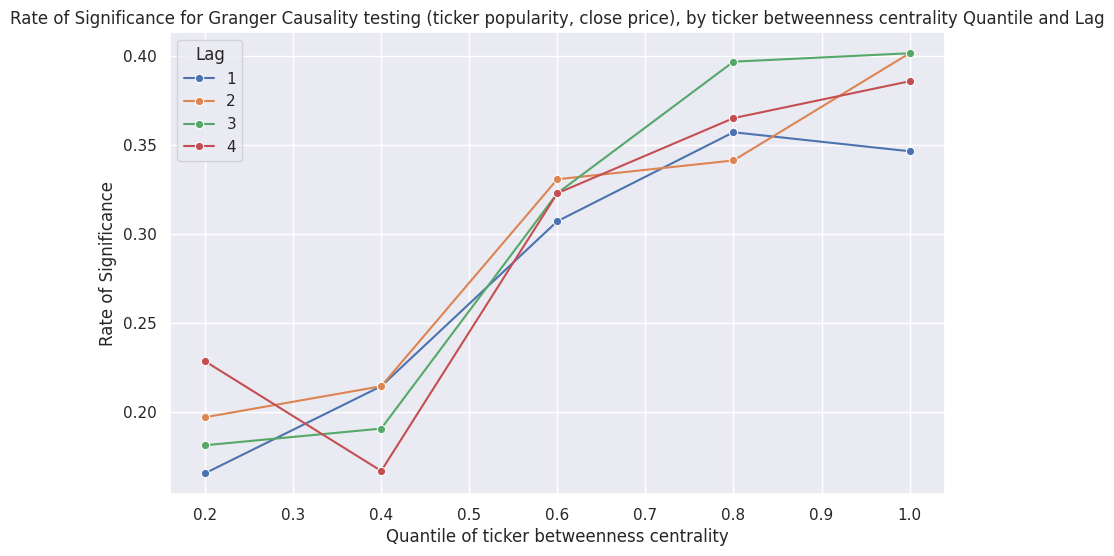

In [ ]:
check_plot(test_f = 'mes_count',by_f = 'weighted_btwn_centrality', t_name = 'ticker popularity', by_name = 'ticker betweenness centrality')

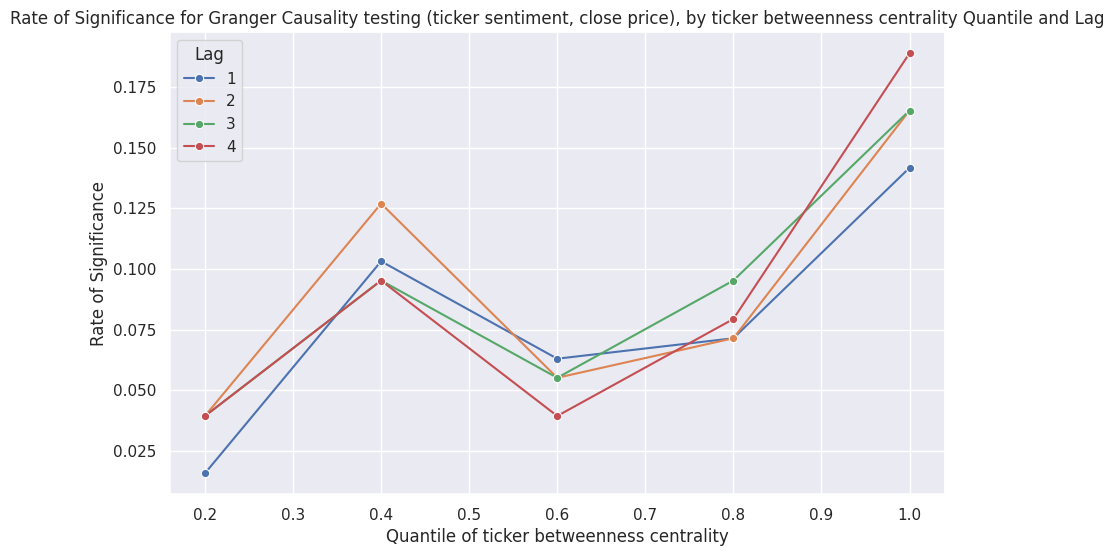

In [ ]:
check_plot(test_f = 'total_bull_rate',by_f = 'weighted_btwn_centrality', t_name = 'ticker sentiment', by_name = 'ticker betweenness centrality')

In [ ]:
gcuse_lag3.head()

,lag,mes_count,user_count,total_bull_rate,user_bull_rate,ticker,user_weight,weighted_btwn_centrality,btwn_centrality,degree_centrality,weighted_degree_centrality,significant,degree_centrality_quantile,btwn_centrality_quantile
3,3,0.8058,0.8058,0.1350,0.2519,SOXL,3.065441,0.000253,0.000420,15.269807,14.848394,0,25% to 50%,lower 25%
8,3,0.2359,0.2359,0.5016,0.4931,SRPT,3.829332,0.001840,0.002813,56.497207,55.400528,0,top 25%,50% to 75%
13,3,0.6293,0.6293,0.0629,0.0596,ABUS,1.824678,0.000516,0.000833,9.530405,9.385285,0,lower 25%,lower 25%
18,3,0.0114,0.0114,0.7953,0.9906,TRVN,25.162307,0.012279,0.009131,20.042975,17.990816,1,50% to 75%,top 25%
23,3,0.0042,0.0042,0.6835,0.6241,DVAX,5.393465,0.001077,0.001523,14.100000,13.867500,1,25% to 50%,25% to 50%


<ipython-input-41-7924e5b8ffc6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcuse_lag3.loc[:, 'significant'] = (gcuse_lag3[test_f] < 0.05).astype(int)
<ipython-input-41-7924e5b8ffc6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcuse_lag3.loc[:, quantile_col_name] = gcuse_lag3.groupby('lag')[by_f].transform(
<ipython-input-41-7924e5b8ffc6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

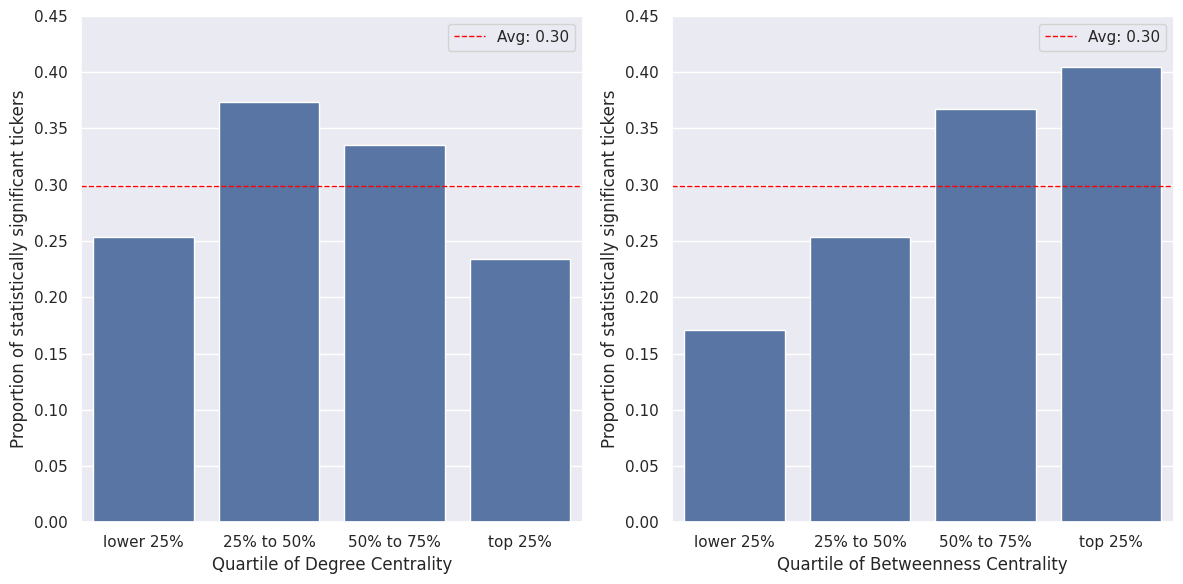

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_significance_rate(gcuse_lag3, test_f, by_f1, by_f2, by_f1_name, by_f2_name, test_name):
    # Step 1: Add the 'significant' column based on mes_count (test_f)
    gcuse_lag3.loc[:, 'significant'] = (gcuse_lag3[test_f] < 0.05).astype(int)

    # Step 2: Add the '{by_f}_quantile' column using pd.qcut for quantile cutting
    for by_f in [by_f1, by_f2]:
        quantile_col_name = f"{by_f}_quantile"

        # Ensure the quantile column is correctly created
        gcuse_lag3.loc[:, quantile_col_name] = gcuse_lag3.groupby('lag')[by_f].transform(
            lambda x: pd.qcut(x, 4, labels=["lower 25%", "25% to 50%", "50% to 75%", "top 25%"])  # Custom labels for quantiles
        )

    # Step 3: Group by quantile columns and calculate the significance rate for each
    significance_rates = {}

    for by_f in [by_f1, by_f2]:
        quantile_col_name = f"{by_f}_quantile"
        rate_of_significance = gcuse_lag3.groupby([quantile_col_name])['significant'].mean().reset_index()
        rate_of_significance.rename(columns={'significant': 'rate_of_significance'}, inplace=True)
        significance_rates[by_f] = rate_of_significance

    # Step 4: Create the subplots for each centrality measure without sharing the y-axis
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    for ax, (by_f, rate_of_significance) in zip(axes, significance_rates.items()):
        sns.barplot(data=rate_of_significance, x=f"{by_f}_quantile", y='rate_of_significance', ax=ax)

        # Calculate the average rate_of_significance
        avg_rate = rate_of_significance['rate_of_significance'].mean()

        # Add a dashed line for the average
        ax.axhline(avg_rate, color='red', linestyle='--', linewidth=1, label=f'Avg: {avg_rate:.2f}')

        # Set title and labels using the provided `by_f1_name` and `by_f2_name`
        ax.set_xlabel(f'Quartile of {by_f1_name if by_f == by_f1 else by_f2_name}')
        ax.set_ylabel('Proportion of statistically significant tickers')

        # Set y-axis range
        ax.set_ylim(0, 0.45)

        # Add legend for the dashed line
        ax.legend()

    # Add the main title for the whole plot
    plt.tight_layout()
    plt.show()

# Example usage:
test_f = 'mes_count'  # Test feature for significance
by_f2 = 'weighted_btwn_centrality'  # First centrality measure
by_f1 = 'weighted_degree_centrality'  # Second centrality measure
by_f2_name = 'Betweenness Centrality'  # Name for by_f2
by_f1_name = 'Degree Centrality'  # Name for by_f1
test_name = 'ticker popularity'
gcuse_lag3 = gcuse.loc[gcuse['lag'] == 3]  # Make sure you use the subset for lag 3
plot_significance_rate(gcuse_lag3, test_f, by_f1, by_f2, by_f1_name, by_f2_name, test_name)


<ipython-input-41-7924e5b8ffc6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcuse_lag3.loc[:, 'significant'] = (gcuse_lag3[test_f] < 0.05).astype(int)
<ipython-input-41-7924e5b8ffc6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcuse_lag3.loc[:, quantile_col_name] = gcuse_lag3.groupby('lag')[by_f].transform(
<ipython-input-41-7924e5b8ffc6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

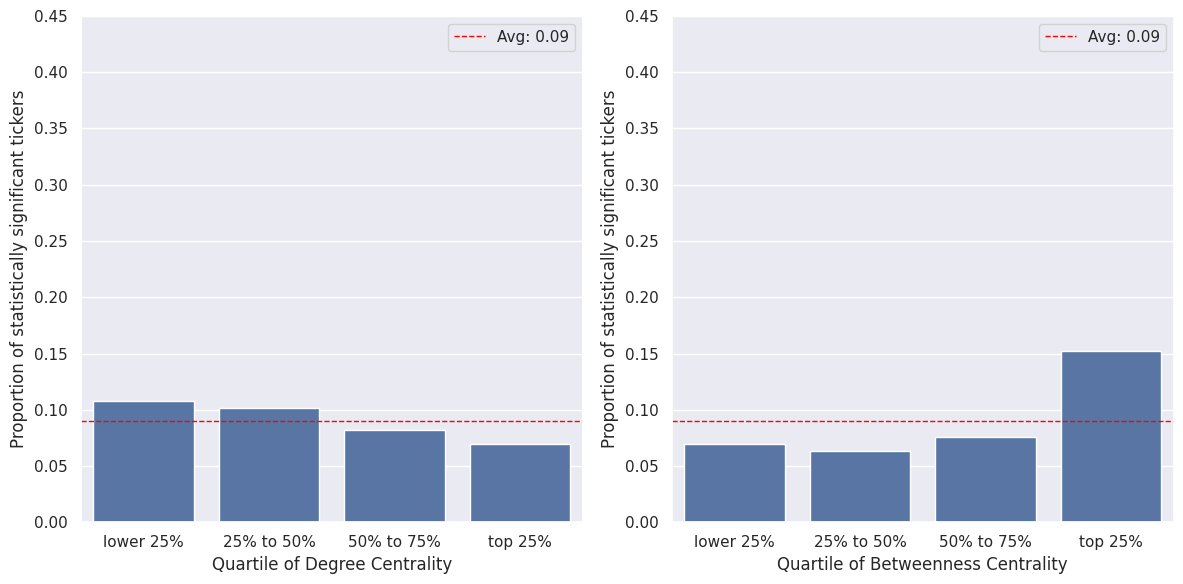

In [ ]:
# Example usage:
test_f = 'total_bull_rate'  # Test feature for significance
by_f2 = 'weighted_btwn_centrality'  # First centrality measure
by_f1 = 'weighted_degree_centrality'  # Second centrality measure
by_f2_name = 'Betweenness Centrality'  # Name for by_f1
by_f1_name = 'Degree Centrality'  # Name for by_f2
test_name = 'ticker sentiment'
gcuse_lag3 = gcuse.loc[gcuse['lag'] == 3]  # Make sure you use the subset for lag 3
plot_significance_rate(gcuse_lag3, test_f, by_f1, by_f2, by_f1_name, by_f2_name, test_name)


<ipython-input-33-66a6654650cc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcuse_lag3.loc[:, 'significant'] = (gcuse_lag3[test_f] < 0.05).astype(int)
<ipython-input-33-66a6654650cc>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcuse_lag3.loc[:, quantile_col_name] = gcuse_lag3.groupby('lag')[by_f].transform(
<ipython-input-33-66a6654650cc>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

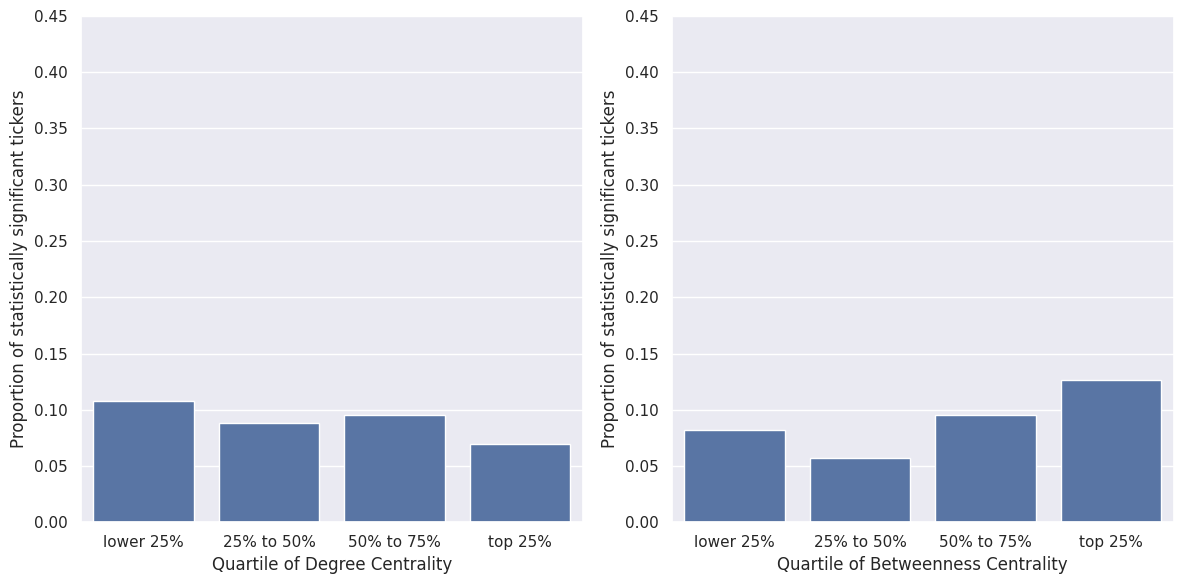

In [ ]:
# Example usage:
test_f = 'total_bull_rate'  # Test feature for significance
by_f2 = 'btwn_centrality'  # First centrality measure
by_f1 = 'degree_centrality'  # Second centrality measure
by_f2_name = 'Betweenness Centrality'  # Name for by_f1
by_f1_name = 'Degree Centrality'  # Name for by_f2
test_name = 'ticker sentiment'
gcuse_lag3 = gcuse.loc[gcuse['lag'] == 3]  # Make sure you use the subset for lag 3
plot_significance_rate(gcuse_lag3, test_f, by_f1, by_f2, by_f1_name, by_f2_name, test_name)


<ipython-input-33-66a6654650cc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcuse_lag3.loc[:, 'significant'] = (gcuse_lag3[test_f] < 0.05).astype(int)
<ipython-input-33-66a6654650cc>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcuse_lag3.loc[:, quantile_col_name] = gcuse_lag3.groupby('lag')[by_f].transform(
<ipython-input-33-66a6654650cc>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

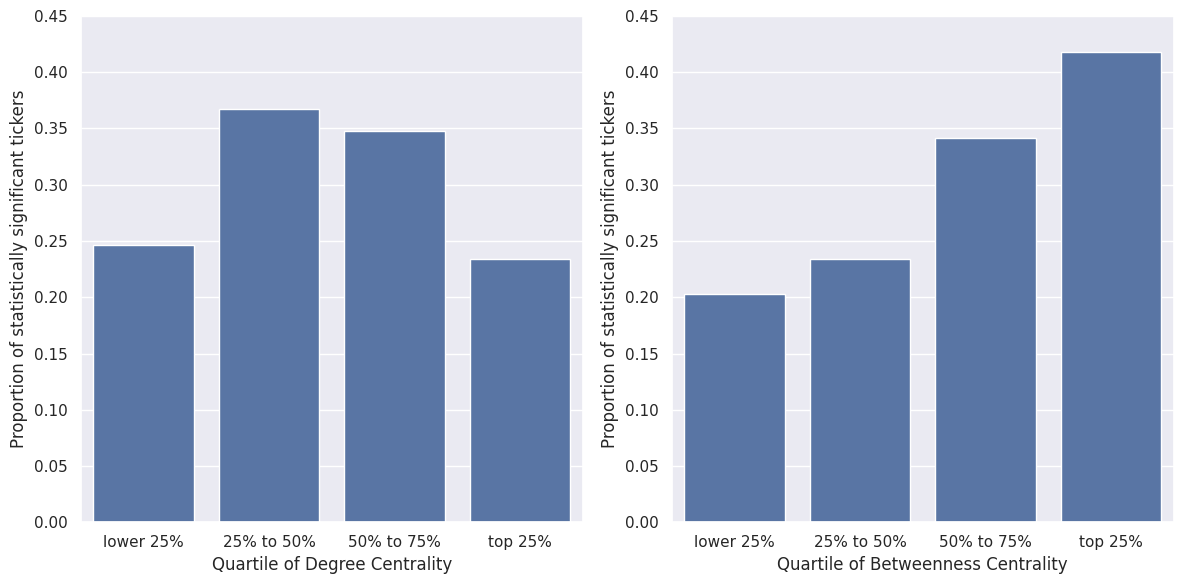

In [ ]:
# Example usage:
test_f = 'mes_count'  # Test feature for significance
by_f2 = 'btwn_centrality'  # First centrality measure
by_f1 = 'degree_centrality'  # Second centrality measure
by_f2_name = 'Betweenness Centrality'  # Name for by_f1
by_f1_name = 'Degree Centrality'  # Name for by_f2
test_name = 'ticker popularity'
gcuse_lag3 = gcuse.loc[gcuse['lag'] == 3]  # Make sure you use the subset for lag 3
plot_significance_rate(gcuse_lag3, test_f, by_f1, by_f2, by_f1_name, by_f2_name, test_name)
